In [1]:
# https://fred.stlouisfed.org/series/IPG2211A2N
# Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) (IPG2211A2N)

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

In [80]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [81]:
df = pd.read_csv('data.csv', parse_dates=[0], index_col=0, date_format = parser)

In [82]:
df.index.name = 'date'

In [83]:
'''
The NAICS code 2211,2 refers to the specific industries included:

NAICS 2211: Electric Power Generation, Transmission, and Distribution

NAICS 2212: Natural Gas Distribution

What Unit Is It In?
The unit for this series is an Index, with 2017 = 100. This means that the value of 100 on the index represents
the average monthly output of electric and gas utilities in the year 2017.
If the index value is, for example, 110, it means the output is 10% higher than the 2017 average.
If the index is 90, the output is 10% lower than the 2017 average.
'''

'\nThe NAICS code 2211,2 refers to the specific industries included:\n\nNAICS 2211: Electric Power Generation, Transmission, and Distribution\n\nNAICS 2212: Natural Gas Distribution\n\nWhat Unit Is It In?\nThe unit for this series is an Index, with 2017 = 100. This means that the value of 100 on the index represents\nthe average monthly output of electric and gas utilities in the year 2017.\nIf the index value is, for example, 110, it means the output is 10% higher than the 2017 average.\nIf the index is 90, the output is 10% lower than the 2017 average.\n'

In [84]:
df.rename(columns={'IPG2211A2N':'unit'}, inplace=True)

In [85]:
df = df.loc['2010-01-01':]

In [86]:
df

,unit
date,
2010-01-01,117.4737
2010-02-01,109.1060
2010-03-01,96.8805
2010-04-01,84.9776
2010-05-01,89.4931
...,...
2025-03-01,100.6731
2025-04-01,93.2445
2025-05-01,95.2159


In [87]:
start_date = datetime(int(df.index[0].split('-')[0]), int(df.index[0].split('-')[1]), int(df.index[0].split('-')[2]))
end_date = datetime(int(df.index[-1].split('-')[0]), int(df.index[-1].split('-')[1]), int(df.index[-1].split('-')[2]))

In [88]:
start_date

datetime.datetime(2010, 1, 1, 0, 0)

In [89]:
fig = px.line(df, x = df.index, y = 'unit',
              title = 'Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)',
              labels = {'unit': 'Index 2017 = 100'})

# Add vertical lines for each year
for year in range(int(start_date.year), int(end_date.year)):
    fig.add_vline(x = pd.to_datetime(f'{year}-01-01'), line = dict(color='black', width = 0.5, dash = 'dash'))
fig.update_xaxes(
    tickmode='linear',
    dtick="M12"
)
fig.show()

In [90]:
first_diff = df.diff()[1:]

In [91]:
fig = px.line(first_diff, x=first_diff.index, y='unit',
              title='Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)',
              labels={'unit': 'Index 2017 = 100'})

# Add vertical lines for each year with transparency
for year in range(int(start_date.year), int(end_date.year)):
    fig.add_vline(
        x=pd.to_datetime(f'{year}-01-01'),
        line=dict(color='rgba(0,0,0,0.8)', width=0.5, dash='dash')
    )

# Show all x-axis labels (one per year)
fig.update_xaxes(
    tickmode='linear',
    dtick="M12"
)

fig.show()

In [92]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [93]:
perform_adf_test(first_diff)

ADF Statistic: -5.937947
p-value: 0.000000


In [94]:
# anomaly detect

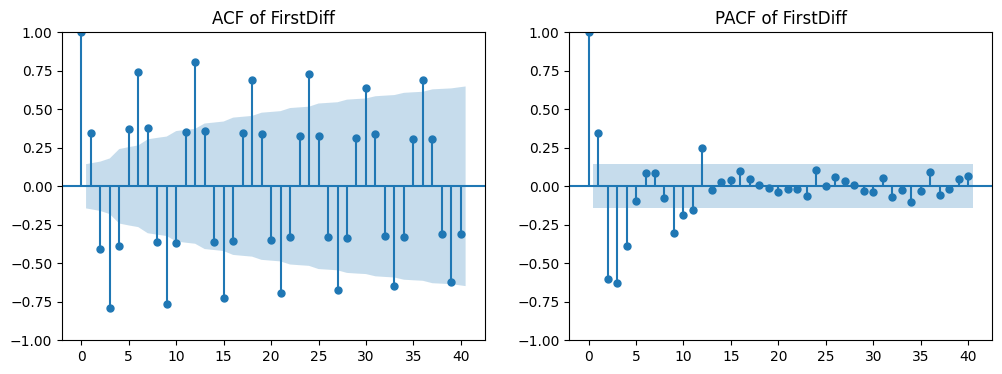

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF
plot_acf(first_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF of FirstDiff')

# Plot PACF
plot_pacf(first_diff, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('PACF of FirstDiff')

# plt.tight_layout()
plt.show()

In [158]:
# p = 4, P = 1 (for P look at multiples of s(12))
# ACF gradually decreases instead of a sharp cutoff so its an AR process q = 0, spiks at multiples of 12. Q = 1 , 2 , 3
# we know 1st difference is necessary for the series so d = 1 and from above graph, acf/pacf plot we can see seasonality exists at lag 12 which means D = 1

In [170]:
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.asfreq('MS')

In [171]:
train_end = datetime(2023, 1, 1)
test_end = datetime(2025, 7, 1)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [ ]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the p, d, q parameters to try
p = range(0, 4)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Seasonal parameters (P, D, Q, s)
P = range(0, 1)
D = range(0, 1)
Q = range(0, 3)
s = 12  # Example seasonal period (monthly data)
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(
                train_data,
                order=param,
                seasonal_order=seasonal_param + (s,)
            )
            model_fit = model.fit()

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)
print("Best AIC:", best_aic)


In [172]:
model = SARIMAX(train_data, order = (4, 1, 0), seasonal_order = (1, 1, 1, 12))

In [173]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 3.590975522994995


In [174]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 unit   No. Observations:                  157
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -372.916
Date:                              Tue, 19 Aug 2025   AIC                            757.832
Time:                                      11:26:03   BIC                            775.651
Sample:                                  01-01-2010   HQIC                           765.072
                                       - 01-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6802      0.330      2.059      0.040       0.033       1.328
ma.L1         -1.31

In [175]:
#get the predictions and residuals
predictions = model_fit.predict(start = train_end, end = test_end)
predictions = pd.Series(predictions, index=test_data.index)
test_data = test_data['unit']
residuals = test_data - predictions

30


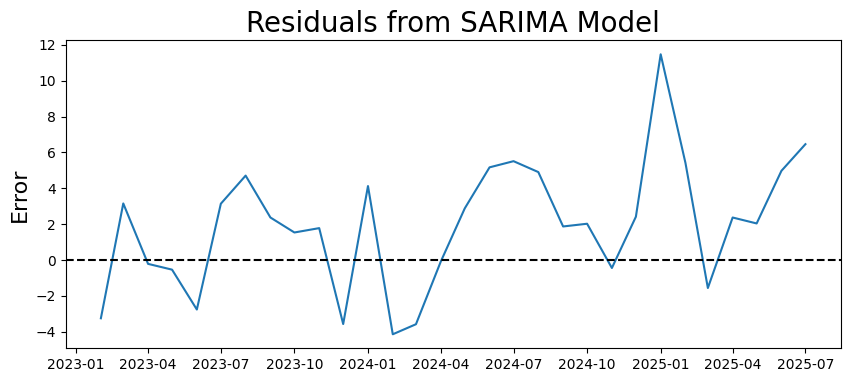

In [176]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
print(len(test_data))

In [177]:
perform_adf_test(residuals)

ADF Statistic: -4.034323
p-value: 0.001241


In [178]:
# check if residuals are white noise
ljung = acorr_ljungbox(residuals, lags=[10, 20, 29], return_df=True)
print(ljung)
# high p val means there isnt sufficient evidence to suggest that theyre correlated so its white noise

      lb_stat  lb_pvalue
10   3.929335   0.950479
20  14.964055   0.778461
29  22.547282   0.796842


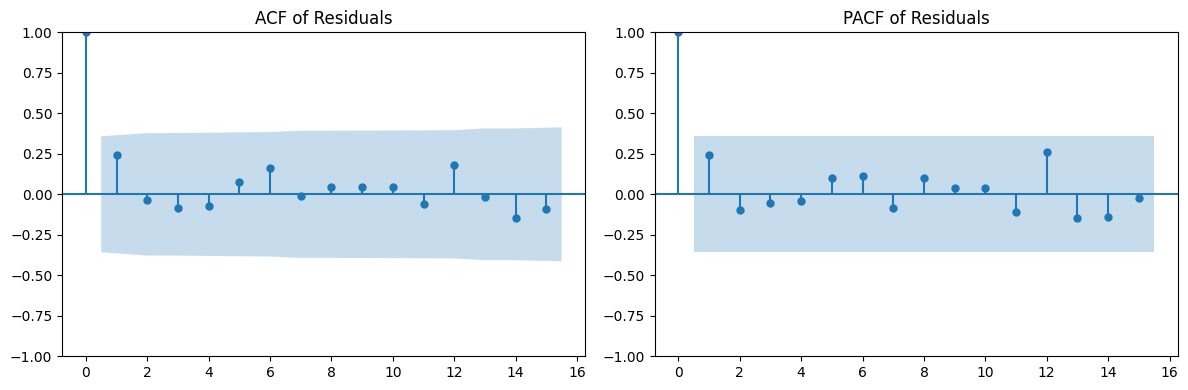

In [179]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(residuals, ax = axes[0])
axes[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax = axes[1])
axes[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

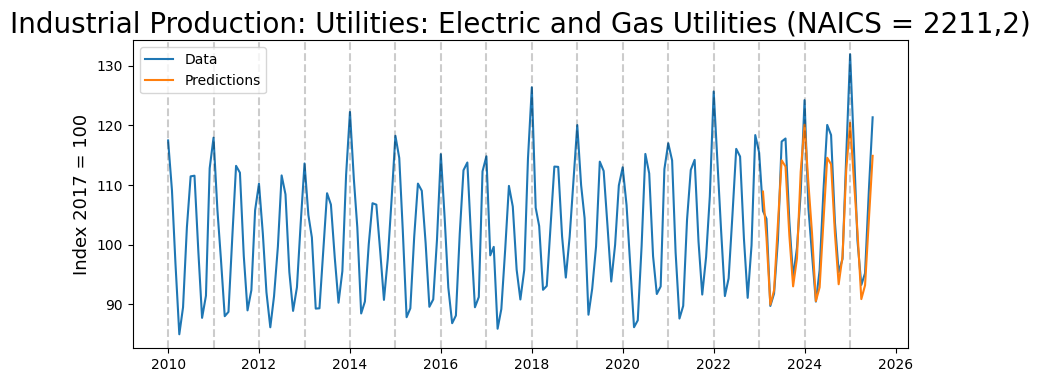

In [180]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))

plt.title('Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)', fontsize=20)
plt.ylabel('Index 2017 = 100', fontsize = 13)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle= '--', alpha = 0.2)

In [181]:
rmse_test = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse_test)


Test RMSE: 3.97375764221705


In [182]:
# Compare train vs test errors to check for overfitting: if train error is low but test error is high, then overfitting might still be happening.

train_pred = model_fit.fittedvalues

train_pred = pd.Series(train_pred, index = train_data.index)

test_pred = predictions

rmse_train = np.sqrt(mean_squared_error(train_data, train_pred))
rmse_test  = np.sqrt(mean_squared_error(test_data, test_pred))

print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)


Train RMSE: 11.152981077987839
Test RMSE: 3.97375764221705


In [38]:
# ---------------------------------------------------------------------

In [39]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order = (4, 1, 0), seasonal_order = (1, 1, 1, 12))
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/tmp/ipython-input-3075978808.py:8: FutureWarning:

Calling float on a single element Series is

In [40]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

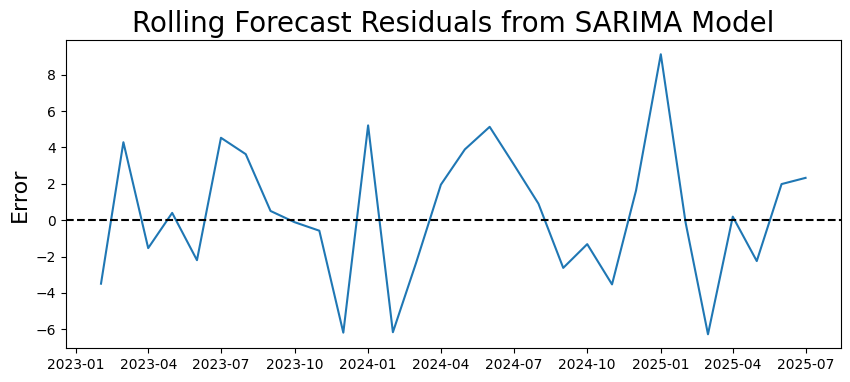

In [41]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [97]:
#Seasonal Differencing

s = 12  # example: monthly data with yearly seasonality
df_season_diff = df - df.shift(s)
fig = px.line(df_season_diff, x=df_season_diff.index, y='unit')

In [98]:
fig.show()

In [99]:
perform_adf_test(df_season_diff.dropna())

ADF Statistic: -3.510254
p-value: 0.007728


In [100]:
df_season_diff

,unit
date,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,NaN
2010-04-01,NaN
2010-05-01,NaN
...,...
2025-03-01,2.3506
2025-04-01,2.7896
2025-05-01,-0.5100
